In [3]:
import numpy as np
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [5]:
def load_data(filename,participant_id):
    df = pd.read_csv(direc + filename,header=None,names=['participant_id','i','ts','info'])
    events = [json.loads(e) for e in df[df['participant_id']==participant_id]['info']]
    return sorted(events,key=lambda e:e['event_time'])

def get_events_with_condition(f,condition):
    return [e for e in f if condition(e)]

def get_event_with_condition(f,condition):
    x = get_events_with_condition(f,condition)
    if len(x)==1:
        return x[0]
    else:
        return {}
    
def get_events_with_type(f,event_type):
    return get_events_with_condition(f,lambda e: e['event_type'].replace('_',' ')==event_type.replace('_',' '))

def get_event_with_type(f,event_type):
    return get_event_with_condition(f,lambda e: e['event_type'].replace('_',' ')==event_type.replace('_',' '))

def check_event_counts(data,num_games):
    event_count_dict = defaultdict(lambda: 0, dict(zip(*np.unique([e['event_type'] for e in data],return_counts=True))))
    print(dict(event_count_dict))
    assert('start game' in event_count_dict and event_count_dict['start game']==num_games)
    assert('end game' in event_count_dict and event_count_dict['end game']==num_games)
    assert(event_count_dict['user move']==event_count_dict['your turn'])
    assert(event_count_dict['opponent move']==event_count_dict['waiting for opponent'])
    assert(event_count_dict['opponent win'] + event_count_dict['user win'] + event_count_dict['draw'] == event_count_dict['start game'])

In [9]:
# directory where your data is stored
#direc = 'C:/Users/groganj/OneDrive - Nexus365/Other/MTurk/' #'C:/Users/svo/Documents/FourinarowData/'
direc = 'C:/Users/groganj/Documents/Work/Experiments/Results/FourInARow/'
#name of the user whose data you want to analyze
usernames = ['debugDGQRE9:debugR28GMK'] #['109:R_1NurOLY6ru1XwrL','R_10pkDu4x8ARiMHf','R_cOwNfKZ17YDGcGR']
#name of your data file
filename = 'trialdata.csv' #'Pilotdata_8yo.csv'
numGames = 20 + 2 # main + practice

In [10]:
data = [load_data(filename,username) for username in usernames]

In [39]:
# check number of moves is >150
def count_moves(data):
    event_count_dict = defaultdict(lambda: 0, dict(zip(*np.unique([e['event_type'] for e in data],return_counts=True))))
    num_moves = event_count_dict['user move']
    return num_moves

num_moves = []
for d in data:
    num_moves.append(count_moves(d))

print(num_moves)

#print(len(get_events_with_type(data[0], 'user move')))



[167]


In [75]:
# count moves per game, and get rt per game

d = data[0]
moves_per_game = []
rt = []
for i, ev in enumerate(d):
    if ev['event_type'] == "start game":
        moves = 0
        rt1 = []
    elif ev['event_type'] == "user move":
        moves += 1
        rt1.append(ev['event_time'] - d[i-1]['event_time'])
    elif ev['event_type'] == "end game":
        moves_per_game.append(moves)
        rt.append(rt1)

print(moves_per_game)
print(sum(moves_per_game))

print(rt)

[4, 10, 8, 6, 5, 5, 6, 8, 15, 7, 7, 6, 7, 8, 4, 9, 9, 9, 18, 6, 6, 4]
167
[[1485, 4279, 9598, 1078], [1675, 1307, 1621, 13710, 6332, 3719, 5965, 20116, 2014, 6140], [2142, 982, 1432, 1667, 1345, 6644, 1695, 936], [2307, 7753, 2119, 3361, 2397, 915], [1981, 1281, 1525, 6145, 978], [2006, 2716, 1230, 1796, 3606], [2493, 2068, 3842, 1783, 2493, 2173], [1236, 3143, 3850, 2075, 6465, 3098, 4851, 9045], [1854, 4359, 2704, 2235, 1087, 9480, 1701, 1133, 1534, 14435, 1535, 10085, 4462, 1129, 1757], [1322, 2186, 4359, 5718, 2322, 12954, 1894], [3037, 3568, 1272, 2129, 9764, 2882, 1319], [1063, 1020, 2334, 7106, 2328, 1465], [1533, 1431, 1307, 1580, 792, 3869, 1337], [3033, 998, 1731, 1606, 1378, 1962, 8725, 13526], [3188, 760, 1075, 760], [874, 2141, 3719, 1497, 2196, 7474, 10372, 6841, 1029], [2076, 1768, 1389, 1771, 1901, 2994, 7331, 8402, 815], [1692, 1416, 1140, 2385, 4105, 7433, 885, 1168, 1177], [2476, 1254, 1196, 3952, 1235, 4881, 2475, 1893, 1047, 12028, 4811, 2719, 12901, 1618, 2288, 14

In [89]:
# check for ceiling/floor in staircasing
# staircasing goes from 0-99? in six categories? 
# may go form 0-240 in categories of 40 (randomly chosen within a category)

def get_start_levels(data):
    # return a list of levels at the start of each game (include practice)
    game_starts = get_events_with_type(data, 'start game') # get level adjustment events
    levels = []
    for game in game_starts: # get the change made
        #print(game)
        levels.append(game['event_info']['level'])
    return levels

def get_outcomes(data):  
    # return a list of outcomes (-1,0,1) at the end of each game 
    game_ends = get_events_with_type(data, 'end game')
    outcomes = [] #-1 = lose, 0 = draw, 1 = win
    for game in game_ends: 
        outcome = game['event_info']['result']
        if outcome == 'win':
            outcomes.append(1)
        elif outcome == 'opponent win':
            outcomes.append(-1)
        elif outcome == 'draw':
            outcomes.append(0)
        else:
            outcomes.append(None)
    return outcomes

def get_level_adjustments(data):
    # returns a list of the level categories after each adjustment at the end of each game
    level_adjusts = get_events_with_type(data, 'adjust level') # get level adjustment events
    level_adjustment = []
    for lev in level_adjusts: # get the change made
        level_adjustment.append(lev['event_info']['category'])
    return level_adjustment



#get data
levels = []
outcomes = []
categories = []
for d in data:
    levels.append(get_start_levels(d))
    categories.append(get_level_adjustments(d))
    outcomes.append(get_outcomes(d))
    
print(levels, outcomes, categories, sep='\n')

[[1, 52, 68, 76, 112, 152, 80, 53, 39, 17, 36, 40, 12, 4, 21, 0, 65, 110, 55, 64, 73, 90]]
[[1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 0, 1, 1, 1]]
[[2, 1, 2, 3, 4, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 2, 2, 2, 3, 4]]


In [79]:
# get RT per move (across all games)

def get_parsed_data(data):
    your_turn_events = get_events_with_type(data,'your turn')
    user_move_events = get_events_with_type(data,'user move')
    assert(len(your_turn_events)==len(user_move_events))
    return [(e['event_info']['bp'],e['event_info']['wp'],e['event_info']['tile'],
             e['event_info']['user_color'],(e['event_time']-e_your_turn['event_time'])/1000)
            for e_your_turn,e in zip(your_turn_events,user_move_events)]

rtAll = []
for d in data:
    for _,_,_,_,rt1 in get_parsed_data(d):
    #bp,wp,m,c,rt = get_parsed_data(d)
          rtAll.append(round(rt1*1000))
print(rtAll)



[1485, 4279, 9598, 1078, 1675, 1307, 1621, 13710, 6332, 3719, 5965, 20116, 2014, 6140, 2142, 982, 1432, 1667, 1345, 6644, 1695, 936, 2307, 7753, 2119, 3361, 2397, 915, 1981, 1281, 1525, 6145, 978, 2006, 2716, 1230, 1796, 3606, 2493, 2068, 3842, 1783, 2493, 2173, 1236, 3143, 3850, 2075, 6465, 3098, 4851, 9045, 1854, 4359, 2704, 2235, 1087, 9480, 1701, 1133, 1534, 14435, 1535, 10085, 4462, 1129, 1757, 1322, 2186, 4359, 5718, 2322, 12954, 1894, 3037, 3568, 1272, 2129, 9764, 2882, 1319, 1063, 1020, 2334, 7106, 2328, 1465, 1533, 1431, 1307, 1580, 792, 3869, 1337, 3033, 998, 1731, 1606, 1378, 1962, 8725, 13526, 3188, 760, 1075, 760, 874, 2141, 3719, 1497, 2196, 7474, 10372, 6841, 1029, 2076, 1768, 1389, 1771, 1901, 2994, 7331, 8402, 815, 1692, 1416, 1140, 2385, 4105, 7433, 885, 1168, 1177, 2476, 1254, 1196, 3952, 1235, 4881, 2475, 1893, 1047, 12028, 4811, 2719, 12901, 1618, 2288, 1495, 836, 906, 1061, 1380, 4398, 2727, 2983, 1122, 2819, 1368, 5896, 1504, 1873, 750, 1533, 1364, 1099, 774]


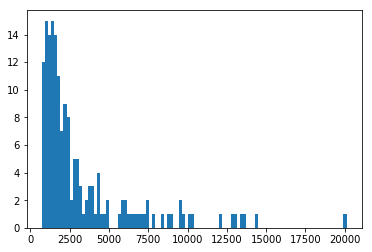

In [83]:
# histogram RT
bins = 100
fig = plt.figure()
plt.hist(rtAll, bins)
plt.xlabel('rt (ms)')
plt.ylabel('freq')
plt.show()

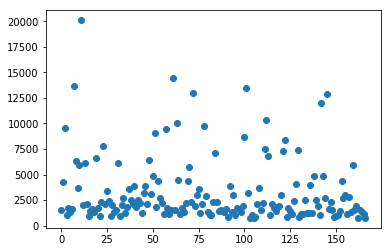

In [86]:
# plot RT per move (across expt)

plt.scatter(range(len(rtAll)), rtAll)
plt.xlabel('move')
plt.ylabel('rt (ms)')

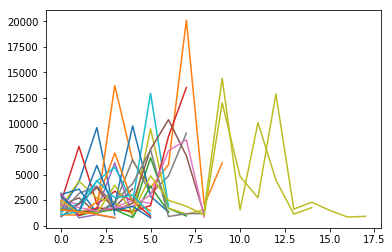

In [87]:
# plot RT across moves in game
fig = plt.figure()
for y in rt:
    plt.plot(y)
plt.xlabel('move within game')
plt.ylabel('rt (ms)')
plt.show()

Text(0,0.5,'outcome')

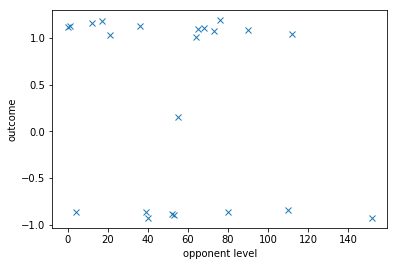

In [99]:
# plot opponent level vs win rate
x = levels[0]
y = outcomes[0]+np.random.rand(len(outcomes[0]))/5 # add random jitter
plt.plot(x, y, 'x')
plt.xlabel('opponent level')
plt.ylabel('outcome')


C:\Users\groganj\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\groganj\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0,0.5,'mean accuracy')

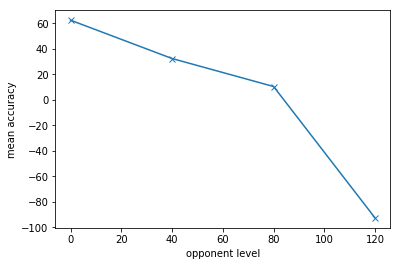

In [131]:
# crude conditional plot
#print(x, y, sep='\n')


bins = range(0,240,40)
yMean = [0]*len(bins)
for i in range(len(bins)):
    inds = [j[0] for j in enumerate(x) if j[1] >= bins[i] and j[1] < bins[i+1]]

    #print(inds)
    yMean[i] = np.mean(y[inds])*100
xMean = bins

#print(yMean)
plt.plot(xMean,yMean,'x-')
plt.xlabel('opponent level')
plt.ylabel('mean accuracy')